## 多智能体强化学习

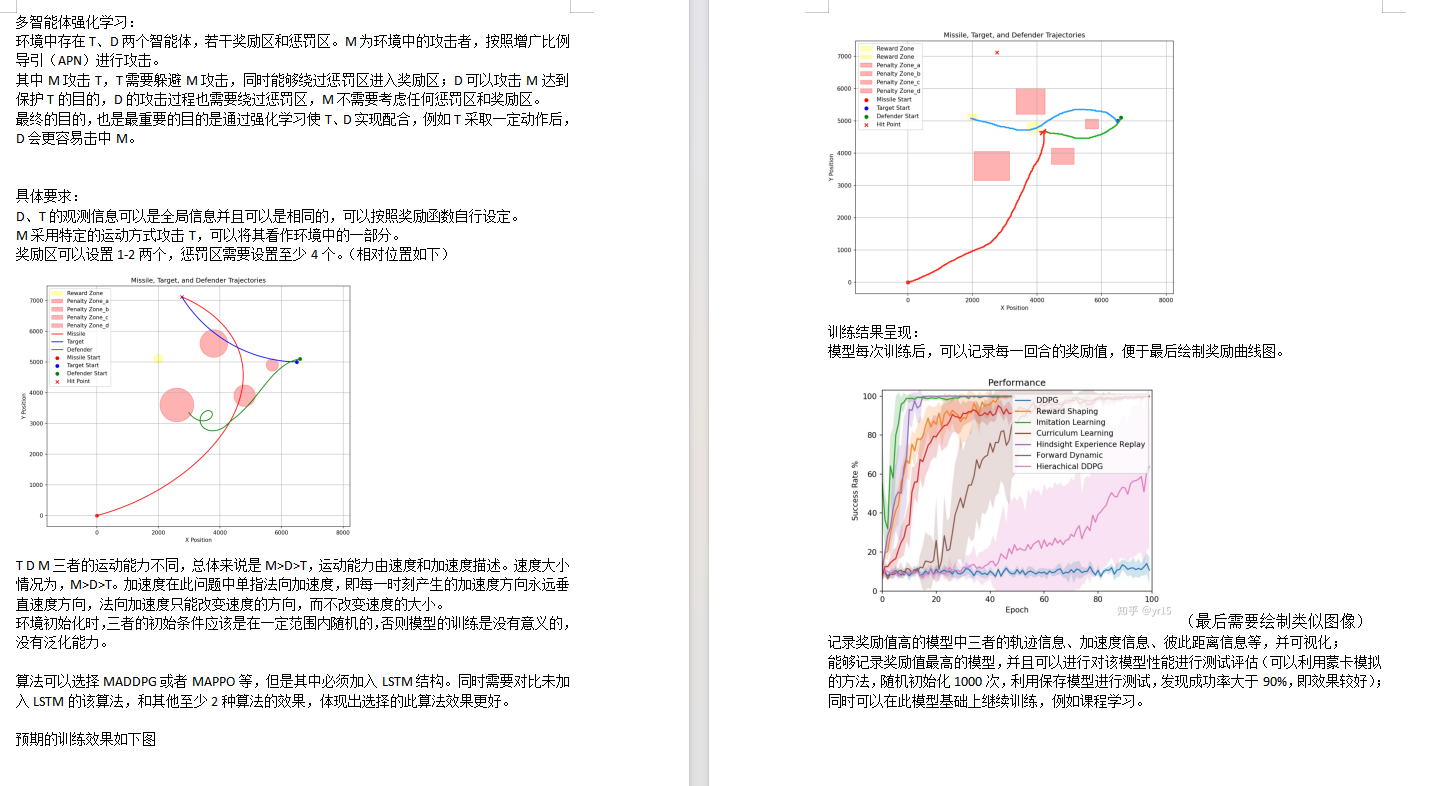

## 思路

环境（观测维度、奖励区、惩罚区、奖励函数等）、策略网络、Value网络已经给出，M是固定策略的导弹。实现MADDPG，训练T、D，主要使D更容易击中T

#### 环境设计    
环境初始化：

    包括地图边界、T、D、M的初始位置、奖励区和惩罚区的位置。为了增加随机性，可以在给定范围内随机生成这些位置。

奖励和惩罚设置：

    奖励区：给T带来正向奖励；D和M不受影响。 
    惩罚区：T和D接触惩罚区会获得负向奖励；M无视惩罚区。 
    D攻击到M时获得额外奖励。

状态观测和运动规则：

    状态观测：T和D都能观察到全局信息，包括所有智能体的位置信息、速度等。
    运动模型：根据设定，M的速度> D > T；三者只能通过法向加速度改变速度方向，速度大小保持不变。  M在Env里每step按固定方式移动，无需训练

APN攻击机制：

    M 基于 APN（Angle of Pursuit Navigation）导引计算自身的加速度和方向。

#### 强化学习算法
算法设计：  

    使用MAPPO算法，同时基于时间序列特征加入LSTM模块进行记忆。   
    对比实验：对比没有LSTM的MAPPO、传统的DQN等算法效果，以验证LSTM在该环境中的有效性。    

奖励函数：  

    奖励函数设计是强化学习成功的关键。我们可以定义奖励函数使得D有利于保护T，而T躲避M并尽可能到达奖励区。示例奖励定义如下：  
    若T进入奖励区，给T较高的奖励。  
    若T、D进入惩罚区，给予负奖励。 
    若D攻击M成功，给D高奖励，同时为T提供一定的协作奖励。    

模型保存和评估：    

    每轮训练后，记录奖励值（T的奖励+D的奖励）并绘制奖励曲线。  
    记录最佳模型的轨迹、加速度和距离信息。  
    使用蒙特卡洛（Monte Carlo）模拟方法测试模型性能，以验证其在随机初始状态下的成功率。 
    引入课程学习（Curriculum Learning）和HER（Hindsight Experience Replay）策略来逐步增强模型的学习效果。 


课程学习（Curriculum Learning）

    课程学习是一种通过逐渐增加任务难度来训练智能体的策略。它的灵感来源于人类教育中的课程设计，通常是在初学者阶段从简单的任务开始，逐渐过渡到更复杂的任务，帮助智能体更容易理解并掌握解决问题的技能。
    具体来说，课程学习的流程通常如下：
    简单任务：智能体首先训练一些简单的任务，逐步掌握基础技能。
    难度递增：随着智能体逐步掌握基础技能，任务的难度会逐渐增加。例如，任务的目标变得更加复杂，或是环境的变化增大。
    最终任务：智能体最终会面临整个任务的挑战，这时它已经具备了足够的能力来解决更复杂的情形。
    应用实例：在机器人学习中，课程学习可能从让机器人学会简单的操作（如抓取物体）开始，逐渐过渡到让它学会在复杂环境中执行精细的任务（如在动态环境中完成抓取任务）。 

### 环境建模

#### param_a用于reward_shaping(HER 失败就改变奖励函数):

        # T 远离 M 的奖励
        dist_to_m = np.linalg.norm(self.T_pos - self.M_pos)
        T_reward -= 5000 * np.exp(-self.param_a * dist_to_m)  # 四位有效数字下e^(-0.1) = 0.9048  e^(-1) = 0.3679  e^(-5) = 0.0067  e^(-10) =  0.00004539   
        # T 靠近奖励区的奖励
        pre_to_R = np.linalg.norm(self.T_trajectory[-1] - reward_zones[0][0])
        cur_to_R = np.linalg.norm(self.T_pos - reward_zones[0][0])
        if cur_to_R < pre_to_R:   T_reward += 100  # 减少距离就奖励
        else:   T_reward -= 10
        # 防止震荡的奖励平滑
        if np.abs(cur_to_R - pre_to_R) < 5.0:
            T_reward += 20  # 平稳行为的奖励

    target要加符号传递给actor, 以逆时针为正方向，则action符号取决于 D速度相对于 M角速度-D角速度 的方向

In [1]:
import numpy as np
from numpy import linalg
import random
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
# torch.backends.cudnn.enabled = True # 强制使用 CUDNN 后端，而不是 MKLDNN
torch.backends.cudnn.deterministic = True  # 确保CUDA卷积结果确定
torch.backends.cudnn.benchmark = False     # 关闭自动寻找最优卷积算法的功能（提升确定性，但可能牺牲性能）
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    def add(self, experience):
        self.buffer.append(experience)
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size) if len(self.buffer) >= batch_size else []
    def __len__(self):
        return len(self.buffer)
def cosine(a,b)->np.float32:# 输入ndarray
    length1 = linalg.norm(a)             
    length2 = linalg.norm(b)             
    dot_product = np.dot(a, b)              
    return dot_product / max(1e-2,length1 * length2)
def projection(v, u)->np.float32:
    return np.dot(v, u) / max(1e-2,linalg.norm(u))
def get_foot(start_point, end_point, point_a)->np.float32: # 求点a 到直线的垂足
    if start_point[0] == end_point[0]:
                p_foot[0] = start_point[0]
                p_foot[1] = point_a[1]
                return p_foot
    x0, y0 = start_point
    x1, y1 = end_point
    x, y = point_a
    p_foot = [0., 0.]
    k = (y1 - y0)*1.0 / (x1-x0 if abs(x1-x0)>1e-2 else np.sign(x1-x0)*1e-2)
    if (y-y0)/(x-x0) == (y1-y0)/(x1-x0): return point_a
    p_foot[0] = (k*(y-y0) +k*k*x0 +x) / (k * k + 1)
    p_foot[1] = (k*k*y +y0 +k*(x-x0)) / (k * k + 1)
    return p_foot
def target_angle(a,b)->np.float32: # 相对速度a与连线b夹角，要逆时针调整则角为正
    sign = np.sign(np.cross(a, b))
    dot = np.dot(a, b)
    norm_b = linalg.norm(b) # 如果norm(b)太小 dot和结果也为0
    cos_theta = np.clip(dot / max(1e-2,linalg.norm(a)*norm_b), -1, 1)  # 安全裁剪
    return np.arccos(cos_theta) * sign
def to_rim(pos,c,r)->np.float32:    # 到圆形边缘距离 若在内则为负
         return np.linalg.norm(pos-c)-r

class MultiAgentEnvironment:
    ''' param_a 指 T_reward -= 5000 * np.exp(-a * dist_to_m)中的a  '''
    def __init__(self, reward_zones, penalty_zones, T_init_angle, reward_shaping=False, balance=0.5, safe_cos=0.95, threshold=1e-3, coef=0.5, coef2=50):
        self.reward_zones = reward_zones
        self.penalty_zones = penalty_zones
        self.reward_shaping = reward_shaping
        self.balance = balance
        self.safe_cos = safe_cos
        self.threshold = threshold
        self.coef = coef
        self.T_init_angle = T_init_angle 
        self.M_hit = 0
        self.coef2 = coef2
        self.reset()
 
    def reset(self, CL=0):
        ''' 返回 [T与奖励区边界距离, T、D与惩罚区边界距离, T与D距离, 三者速度在各自目标连线上投影, T、D速度在各惩罚区视线上投影] '''
        self.curriculum_learning = CL # 课程学习分成两阶段
        self.success = False
        self.T_pos = np.array([6400, 5000], dtype=np.float32)
        self.D_pos = np.array([6399, 5000], dtype=np.float32)   # 假设由T抛出
        self.M_pos = np.array([0, 0], dtype=np.float32)
        self.D_on_MT_foot = get_foot(self.M_pos, self.T_pos, self.D_pos)
        self.T_on_MD_foot = get_foot(self.M_pos, self.D_pos, self.T_pos)
        self.T_trajectory, self.D_trajectory, self.M_trajectory = [list(self.T_pos)], [list(self.D_pos)], [list(self.M_pos)]
        self.target = 0 # norm(self.D_omega-self.M_omega)
        self.x = target_angle(self.D_pos-self.T_pos,self.M_pos-self.T_pos)/np.pi
        self.acc = np.array([[0,0],[0,0],[0,0]], dtype=np.float32)    # 记录T、D、M的加速度
        # 随机化 T 和 D 的初始方向, M 指向 T 初始点
        if CL==0:
            random_angle_T = np.random.uniform(self.T_init_angle-np.pi/8, self.T_init_angle+np.pi/8 )
        else:
            random_angle_T = np.random.uniform(self.T_init_angle-np.pi/8, self.T_init_angle+np.pi/8 )
        self.T_velocity = 17.5 * np.array([np.cos(random_angle_T), np.sin(random_angle_T)])
        self.D_velocity = 25 * np.array([np.cos(random_angle_T), np.sin(random_angle_T)]) # 初始与T通向
        self.M_velocity = 35 * (self.T_pos - [0, 0]) / linalg.norm(self.T_pos-self.M_pos)
        self.M_omega, self.D_omega = np.array([0,0],dtype=np.float32), np.array([0,0],dtype=np.float32)
        self.D_foot_v, self.T_foot_v = np.array([0,0],dtype=np.float32), np.array([0,0],dtype=np.float32)
        self.cos = cosine(self.D_pos-self.T_pos,self.M_pos-self.T_pos)
        self.D_to_M = linalg.norm(self.D_pos - self.M_pos)
        return self.get_observation()

    def step(self, T_action, D_action): # 返回状态观测、两者的奖励r(s,a) 以及是否终止
        ''' 更新 T, D, M 的位置和速度。速度：M> D> T 1个step是0.1秒'''
        cos_T_on_re = cosine(self.T_velocity, reward_zones[0][0]-self.T_pos)
        self.acc = []
        self.T_pos, self.T_velocity = self.update_position(self.T_pos, T_action, self.T_velocity, speed=17.5) # TODO: 调, 设M速率 > 1马赫 ≈ 340m/s = 34m/step 
        self.D_pos, self.D_velocity = self.update_position(self.D_pos, D_action, self.D_velocity, speed=21)
        self.M_pos, self.M_velocity = self.compute_M_action(speed=35)
        ''' T到DM/D到TM 垂足是动点，解微分方程得到其速度计算公式 '''
        DM,TM = self.M_pos - self.D_pos, self.M_pos - self.T_pos
        DM_sq, TM_sq = max(1e-2,np.dot(DM,DM)), max(1e-2,np.dot(TM,TM))
        self.T_foot_v = self.D_velocity + (((self.T_velocity-self.D_velocity)*DM+(self.T_pos-self.D_pos)*(self.M_velocity-self.D_velocity))/DM_sq - 2*((self.T_pos-self.D_pos)*DM* DM*(self.M_velocity-self.D_velocity))/DM_sq**2) * DM + (self.T_pos-self.D_pos)*DM/DM_sq *(self.M_velocity-self.D_velocity)
        self.D_foot_v = self.T_velocity + (((self.D_velocity-self.T_velocity)*TM+(self.D_pos-self.T_pos)*(self.M_velocity-self.T_velocity))/DM_sq - 2*((self.D_pos-self.T_pos)*TM* TM*(self.M_velocity-self.T_velocity))/TM_sq**2) * TM + (self.D_pos-self.T_pos)*TM/TM_sq *(self.M_velocity-self.T_velocity)
        # 记录轨迹
        self.T_trajectory.append(list(self.T_pos))
        self.D_trajectory.append(list(self.D_pos))
        self.M_trajectory.append(list(self.M_pos))
        self.D_on_MT_foot = get_foot(self.M_pos, self.T_pos, self.D_pos)

        ''' 每个step结算本次的奖励  '''
        T_reward, D_reward, D_reward_HER = 0, 0, 0

        # --- 防御者D 与 目标T的最终协作奖励 ---
        self.D_to_M = np.linalg.norm(self.D_pos - self.M_pos)
        D_reward += 50 * self.coef2/self.D_to_M
        if self.D_to_M < 30.0: # 
            D_reward += 20000  # 成功防御奖励 
            T_reward += 10000  # T 的最终协作奖励

        # --- 共同的奖励函数 与 T的奖励塑形 ---
        T_reward += self.zones_reward(self.T_pos)
        self.cos = cosine(self.D_pos-self.T_pos,self.M_pos-self.T_pos)
        # 视角差,若大于安全角 则调整为小于safe_cos的锐角
        if self.cos < self.safe_cos: 
            D_reward += -200 + 50*(np.exp(self.cos+1)-np.e) # x在-1~1时 exp(x+1)- e 增长比x快
        # 以T为圆心求D、M两者相对T切向角速度的差的模长target 能指导状态价值函数但不能指导动作
        else:
            self.M_omega = (self.M_velocity-self.T_velocity-projection(self.M_velocity-self.T_velocity,self.T_pos-self.M_pos))/max(1e-2,linalg.norm(self.M_pos-self.T_pos))
            self.D_omega = (self.D_velocity-self.T_velocity-projection(self.D_velocity-self.T_velocity,self.D_pos-self.T_pos))/max(1e-2,linalg.norm(self.D_pos-self.T_pos))
            self.target = linalg.norm(self.D_omega-self.M_omega)
            if self.target < self.threshold:   #TODO: 奖励D接近M的相对角速度并且保持三点一线
                T_reward += 50*(np.exp(self.cos)-1); D_reward += 50*(np.exp(self.cos)-1) # x在0~1时 exp(x)-1 > x 且增长更快
            else:
                T_reward += max(50*(-4+np.exp(self.safe_cos+1)-np.e), -self.coef*(self.target/self.threshold)**3)
                D_reward += max(50*(-4+np.exp(self.safe_cos+1)-np.e), -self.coef*(self.target/self.threshold)**3)
        # T的奖励塑形：谨慎设置中间奖励 躲避M≠远离M、靠近reward
        if self.reward_shaping: 
            #T_to_M = np.linalg.norm(self.T_pos - self.M_pos)
            #T_reward = self.coef2 * T_to_M # 注意变量x在0.1附近时 函数exp(-x)剧增：约 0.905， 0.5时 0.607， 1时 0.368， 2时 0.135
            self.T_on_MD_foot = get_foot(self.M_pos, self.D_pos, self.T_pos)
            cos_T_on_hide = cosine(self.T_velocity-self.T_foot_v, self.T_on_MD_foot-self.T_pos)
            T_reward += 100*  self.balance  *(np.exp(cos_T_on_hide)-1)
            T_reward += 100*(1-self.balance)* (np.exp(cos_T_on_re)-1)
        #  在CL二阶段，设置惩罚区 
        if self.curriculum_learning:
            T_reward -= self.zones_penalty(self.T_pos)

        # --- 终止条件 ---
        done = self.check_termination()
        obs = self.get_observation()
        if done and not self.success:      # T若被击中
            T_reward -= 10000; D_reward -= 10000
        # 分层强化学习与课程学习：在CL二阶段,  若拦截成功则在buffer添加下面记录的另一个奖励函数（HER 的一种实现），鼓励 D 规避惩罚区。
        D_reward_HER = D_reward
        if self.curriculum_learning:
            D_reward_HER -= self.zones_penalty(self.T_pos)

        return obs, (T_reward, D_reward, D_reward_HER), done
    
    """ action是单元素向量, 取值[-1, 1], 表示采取多大的加速度, 设加速度上限a_max T、D相同为(35m/s)/s= (3.5m/s)/step= 0.35m/step/step, M为0.3m/step/step  """
    """ 有需要请在update_position和compute_M_action里调整加速度上限"""
    def update_position(self, pos, action, velocity, speed): 
        ''' delta_v大小为action*0.35 以逆时针变向为正'''
        delta_v = action * 0.35   # TODO: 加速度上限调整
        current_direction = velocity / speed # 单位向量表示速度的方向
        normal_vector = np.array([-current_direction[1], current_direction[0]])
        new_velocity = current_direction * speed + normal_vector * delta_v
        new_velocity = speed * new_velocity / max(1e-2,linalg.norm(new_velocity))
        self.acc.append(normal_vector * delta_v)
        return pos + new_velocity, new_velocity 
    def compute_M_action(self,speed):
        """        APN 导引，计算 M 的加速度。逆时针变向则speed_adjustment值为正。      """
        # 导引增益，经验值
        N = 3 - 0.5* linalg.norm(self.T_pos - self.M_pos)/max(1e-2, linalg.norm(np.array([6400, 5000])))
        # T 相对 M 的速度
        MT = self.T_pos - self.M_pos
        relative_v = self.T_velocity - self.M_velocity
        # 法向加速度大小限制
        max_speed_adjustment = 0.3      # TODO: 加速度上限调整
        # 视线角速率
        line_of_sight_rate = np.cross(MT, relative_v) / max(1e-2, np.linalg.norm(MT)**2)
        # 接近速度
        Vc = np.dot(relative_v, MT) / max(1e-2, np.linalg.norm(MT))
        # 法向加速度大小
        a_T_normal = projection(self.acc[0], np.array(-MT[1],MT[0]))
        speed_adjustment = - N*line_of_sight_rate*Vc + 0.5*a_T_normal # N 是增益
        speed_adjustment = np.clip(speed_adjustment, -max_speed_adjustment, max_speed_adjustment) # clip()截断超过介值的元素
        # 法向加速度方向为逆时针法向
        current_direction = self.M_velocity / speed
        normal_vector = np.array([-current_direction[1], current_direction[0]])  # 法向单位向量
        # 更新速度
        M_delta_v = speed_adjustment* normal_vector
        self.acc.append(M_delta_v)
        new_v = self.M_velocity + M_delta_v
        self.M_velocity = speed * (new_v) / max(1e-2,linalg.norm(new_v))
        # 更新位置和速度
        return self.M_pos + self.M_velocity, self.M_velocity
    def zones_reward(self, pos): # 每持续1个step 都会被奖励/处罚
        reward = 0
        for zone in self.reward_zones: # 每个zone是 由中心点坐标tuple和半径int组成的list
            if self.in_zone(pos, zone): reward += 500
        return reward
    def zones_penalty(self, pos): # 每持续1个step 都会被奖励/处罚
        penalty = 0
        for zone in self.penalty_zones:                 
            if self.in_zone(pos, zone): penalty += 10
        return penalty   
    def in_zone(self, pos, zone):
            center, radius = zone
            return np.linalg.norm(pos - center) < radius
    
    def get_observation(self):
        ''' 观测: 加速度在相对速度的投影, T、D的各目标角, 加速度，加速度差,
          距离（若要靠近）或距离倒数（若要排斥）*cos夹角 【紧迫程度、调整幅度】 '''
        ''' 加速度相关观测除以0.35因为update_position把动作输出*0.35作为加速度，角度除以派映射到[-1,1] '''
        # 向量到目标向量是否为逆时针
        sig = np.sign(np.cross(self.D_velocity, self.M_omega-self.D_omega))
        Tsasig = np.sign(np.cross(self.T_velocity,self.T_foot_v))
        Dsasig = np.sign(np.cross(self.D_velocity,self.D_foot_v))
        # 相对速度到目标位置的角度
        vD_safe_theta = target_angle(self.D_velocity-self.D_foot_v, self.D_on_MT_foot-self.D_pos)/np.pi
        vD_M_theta = target_angle(self.D_velocity-self.M_velocity, self.M_pos-self.D_pos)/np.pi
        vT_safe_theta = target_angle(self.T_velocity-self.T_foot_v, self.T_on_MD_foot-self.T_pos)/np.pi
        vT_re_theta = target_angle(self.T_velocity, self.reward_zones[0][0]-self.T_pos)/np.pi
        penalty_thetas = np.concatenate([ [target_angle(self.T_velocity,c-self.T_pos), target_angle(self.D_velocity,c-self.D_pos)] for c,_ in self.penalty_zones])/np.pi
        # 加速度，加速度差
        aD = sig*linalg.norm(self.acc[1])/0.35
        aT_on_safe = projection(self.acc[0], self.T_foot_v-self.T_velocity)/0.35 * Tsasig
        aM_minus_aD = linalg.norm(self.acc[2]-self.acc[1])/0.35 * np.sign(np.cross(self.acc[1], self.acc[2]-self.acc[1])) # aD到aM-aD是逆时针则正
        aM_minus_aD_on_vT = projection(self.acc[2]-self.acc[1], self.T_velocity)/0.35 * np.sign(np.cross(self.acc[1], self.acc[2]-self.acc[1]))
        # 距离（若要靠近）/距离倒数（若要排斥）*cos夹角【紧迫程度、调整幅度】
        D_on_safe = linalg.norm(self.D_on_MT_foot-self.D_pos) *cosine(self.D_velocity-self.D_foot_v,self.D_on_MT_foot-self.D_pos) * Dsasig
        T_on_safe = linalg.norm(self.T_on_MD_foot-self.T_pos) *cosine(self.T_velocity-self.T_foot_v,self.T_on_MD_foot-self.T_pos) * Tsasig
        c = reward_zones[0][0]
        T_on_re = linalg.norm(c-self.T_pos) *cosine(self.T_velocity,c-self.T_pos)* np.sign(np.cross(self.T_velocity, c-self.T_pos))
        T_on_pzs = np.array([ 1/max(1e-2,linalg.norm(c-self.T_pos)) *cosine(self.T_velocity,c-self.T_pos)*np.sign(np.cross(self.T_velocity, c-self.T_pos)) for c, _ in self.penalty_zones ])
        D_on_pzs = np.array([ 1/max(1e-2,linalg.norm(c-self.D_pos)) *cosine(self.D_velocity,c-self.D_pos)*np.sign(np.cross(self.D_velocity, c-self.D_pos)) for c, _ in self.penalty_zones ])
        return np.concatenate([[aT_on_safe, aD+aM_minus_aD, aD+aM_minus_aD_on_vT, sig*self.target, vD_safe_theta, vD_M_theta, vT_safe_theta, vT_re_theta],penalty_thetas,[D_on_safe, T_on_safe, T_on_re],T_on_pzs,D_on_pzs] ) # 3+1+ 4+8 + 3+8

    def check_termination(self):
        '''    T到达奖励区(逃离)、D击中M(防御) 或M击中T(失败)  设破片云密集区域半径25米 程序判定阈值比真实要高 '''
        if self.in_zone(self.T_pos, self.reward_zones[0]) or np.linalg.norm(self.D_pos - self.M_pos) < 32.0:
            self.success  = True
            return True
        if np.linalg.norm(self.T_pos - self.M_pos) < 32.0:
            self.M_hit += 1
            return True
        return False


'''     惩罚区和奖励区，可调整     '''
reward_zones = [(np.array([2000, 5050]), 100)]
penalty_zones = [(np.array([2500, 3600]), 500), (np.array([4800, 3900]), 300),
                     (np.array([3900, 5600]), 450), (np.array([5700, 4900]), 150)]

## MASAC
中心化训练critic 各自训练actor 注意形状参数  动手学强化学习P232

In [2]:
def plot_trajectories(trajectories):
    """ 可视化 T、D、M 的轨迹 """
    plt.figure(figsize=(10, 8),dpi=120)
    colors = ['r', 'g', 'b', 'y', 'm']  # 不同颜色区分轨迹
    # 绘制奖励区
    for center, radius in reward_zones:
        circle = plt.Circle(center, radius, color='Yellow', alpha=0.3, label='Reward Zone')
        plt.gca().add_patch(circle)
    # 绘制惩罚区
    for center, radius in penalty_zones:
        circle = plt.Circle(center, radius, color='red', alpha=0.3, label='Penalty Zone')
        plt.gca().add_patch(circle)

    for idx, traj in enumerate(trajectories):
        T_trajectory = np.array(traj[0])
        D_trajectory = np.array(traj[1])
        M_trajectory = np.array(traj[2])

        color = colors[idx % len(colors)]
        plt.plot(T_trajectory[:, 0], T_trajectory[:, 1], f'{color}-', label=f'T Episode {idx+1}')
        plt.plot(D_trajectory[:, 0], D_trajectory[:, 1], f'{color}--', label=f'D Episode {idx+1}')
        plt.plot(M_trajectory[:, 0], M_trajectory[:, 1], f'{color}:', label=f'M Episode {idx+1}')

    plt.title("Successful Trajectories of T, D, and M")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
torch.__version__

'2.7.1+cu126'

在强化学习中，无需批标准化（BN）。智能体 (agent) 训练越快，BN 越难以发挥作用。与监督训练不同，RL 的智能体需要通过**「经验回放」技术与环境交互**来获取训练数据，这些数据无法在开始前就准备好（给定）。所以 RL 无法为 BN 提供足够稳定的训练数据，每当训练数据发生变化（智能体搜集到大量新的状态 state），而 BN 来不及适应新的数据，造成估值函数和策略函数相继奔溃（估值函数的估值不准，策略函数的策略退化）。

### 含 LSTM 且最终版
在许多深度学习框架中，例如 PyTorch 和 TensorFlow，如果你不显式地初始化 ℎ 0  和 𝑐 0 ，它们通常会被默认初始化为零向量。对于大多数应用场景，零初始化已经足够。在PyTorch中，默认情况下，LSTM的激活函数为双曲正切函数(tanh)，而在Keras中，默认的激活函数为双曲正切函数(tanh)和逐元素修正的线性单元函数(ReLU)的组合。batch_first=True

【深入理解PyTorch中LSTM的输入和输出 https://blog.csdn.net/Cyril_KI/article/details/122557880 】————人工智能领域优质创作者 粉丝12万 天津大学

如果在初始化LSTM时令batch_first=True，那么input和output的shape将变为：

    input(batch_size, seq_len, input_size)
    output(batch_size, seq_len, num_directions * hidden_size)

In [11]:
GRU = False  # LSTM层替换为GRU否
from torch.distributions import Normal
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, hidden_size, action_dim, num_layers=1):         # 本例为 obs_dim, 128, 1
        super(PolicyNet, self).__init__()
        #self.LN = nn.LayerNorm(4, eps=1e-6) # 最后一个维度大小为4，因此normalized_shape是4
        self.rnn = nn.GRU(obs_dim, hidden_size, num_layers, batch_first=True) if GRU else nn.LSTM(obs_dim, hidden_size, num_layers, batch_first=True)
        print('使用GRU...' if GRU else '使用LSTM...')
        self.fc1 = nn.Linear(hidden_size, int(hidden_size/4))
        self.fc_mu = torch.nn.Linear(int(hidden_size/4), action_dim)
        self.fc_std = torch.nn.Linear(int(hidden_size/4), action_dim)

    def forward(self, x, hidden_state):
        if isinstance(hidden_state, tuple):  # LSTM的(h_n, c_n)
            hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())
        else:  # GRU的 h_n
            hidden_state = hidden_state.detach()
        rnn_out, hidden_state = self.rnn(x, hidden_state) # x 为(batch_size=64, seq=1, input_size)
        x = rnn_out.squeeze(1)
        x = torch.tanh(self.fc1(x))    
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample() # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        return action, log_prob, hidden_state
# Value Network
class ValueNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, int(hidden_size/4)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/4), hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Tanh()  # 输出范围为[-1, 1]
        )
    def forward(self, x, a):
        cat = torch.cat([x, a], dim=-1)
        return self.net(cat)

In [12]:
# MADDPG Agent with GRU/LSTM 
device = torch.device('cpu')
class MASACAgent:
    def __init__(self, obs_dim, action_dim, target_entropy, agent_id, init_log_alpha=0.01, hidden_dim=128, actor_lr=1e-3, critic_lr=1e-3, tau=1e-3, gamma=0.99):
        self.device = device
        self.obs_space = obs_dim
        self.action_space = action_dim
        self.agent_id = agent_id
        self.tau = tau
        self.gamma = gamma
        self.hidden_size = hidden_dim
        self.target_entropy = target_entropy # 目标熵的大小
        # 策略网络
        self.actor = PolicyNet(obs_dim, hidden_dim, action_dim).to(device)
        # 第一个Q网络
        self.critic_1 = ValueNet(obs_dim, action_dim, hidden_dim).to(device)
        #第二个Q网络
        self.critic_2 = ValueNet(obs_dim, action_dim, hidden_dim).to(device)
        # 目标 Q网络
        self.target_critic_1 = ValueNet(obs_dim, action_dim, hidden_dim).to(device)
        self.target_critic_2 = ValueNet(obs_dim, action_dim, hidden_dim).to(device)
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.AdamW(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.AdamW(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.AdamW(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值，可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(init_log_alpha), dtype=torch.float)
        self.log_alpha.requires_grad = True     # 能够对alpha求梯度
        self.log_alpha_optimizer = torch.optim.AdamW([self.log_alpha], lr=3e-4)
        # 用于存储经验的回放池
        self.replay_buffer = ReplayBuffer(buffer_size=100000)

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def act(self, obs, hidden_state=None, noise_scale=0.0):
        if hidden_state == None:
            hidden_state = torch.zeros(1, self.hidden_size).to(device) if GRU else (torch.zeros(1, self.hidden_size).to(device), torch.zeros(1, self.hidden_size).to(device))
        else:
            hidden_state = hidden_state[:,-1,:] if GRU else (hidden_state[0][:,-1,:], hidden_state[1][:,-1,:])

        obs = torch.FloatTensor(obs).unsqueeze(0).to(device)  # 添加 batch 维度
        with torch.no_grad(): # 由于不需更新隐藏层
            action,_,_ = self.actor(obs, hidden_state)
            action = action[0] + noise_scale * torch.randn_like(action)  # 添加噪声以进行探索
        return action.item()

    def calc_target(self, rewards, next_states, dones, hidden_state): # 计算目标Q值
        with torch.no_grad(): # 由于不需更新隐藏层
            next_actions, log_prob, _ = self.actor(next_states, hidden_state)
        entropy =- log_prob
        q1_value = self.target_critic_1(next_states, next_actions.unsqueeze(1).to(device)).squeeze(1)
        q2_value = self.target_critic_2(next_states, next_actions.unsqueeze(1).to(device)).squeeze(1)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards.unsqueeze(1) + self.gamma * next_value * (1 - dones).unsqueeze(1)
        return td_target, hidden_state

    def learn(self, replay_buffer, hidden_state=None, batch_size=1024):
        if len(replay_buffer) < batch_size:
            return
        batch = replay_buffer.sample(batch_size) # 是tuple的list
        if self.agent_id=='T':
            states, actions, _, rewards, _, next_states, dones = zip(*batch) # 变向，把原来的每一列变成tuple取出
        if self.agent_id=='D':
            states, _, actions, _, rewards, next_states, dones = zip(*batch)     
        # 转换输入数据为Tensor
            # 用于critic的观测输入与actor略有不同 有一项要加绝对值
        c_states,next_c_states = np.array(states),np.array(next_states)
        for i,x in enumerate(next_states):
            c_states[i][3:16] = tuple(map(lambda x: abs(x), x[3:16]))
        for i,x in enumerate(next_c_states):
            next_c_states[i][3:16] = tuple(map(lambda x: abs(x), x[3:16]))

        states = torch.FloatTensor(np.array(states)).unsqueeze(1).to(device) # torch.Size([batch_size, 1, 21])
        c_states = torch.FloatTensor(c_states).unsqueeze(1).to(device) # torch.Size([batch_size, 1, 21])
        actions = torch.FloatTensor(np.array(actions)).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).unsqueeze(1).to(device)
        next_c_states = torch.FloatTensor(next_c_states).unsqueeze(1).to(device)
        
        dones = torch.FloatTensor(np.array(dones)).to(device)
        if hidden_state == None: # 初始化隐藏层
            # print(self.agent_id+'_hidden_state initialization.')
            hidden_state = torch.zeros(1, batch_size, self.hidden_size).to(device) if GRU else (torch.zeros(1, batch_size, self.hidden_size).to(device), torch.zeros(1, batch_size, self.hidden_size).to(device))

        #更新两个Q网络
        td_target, _ = self.calc_target(rewards, next_c_states, dones, hidden_state)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(c_states.squeeze(1), actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(c_states.squeeze(1), actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()
        # 更新策略网络
        new_actions, log_prob, hidden_state = self.actor(states, hidden_state)
        entropy = -log_prob
        ql_value = self.critic_1(states.squeeze(1),new_actions)
        q2_value = self.critic_2(states.squeeze(1),new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(ql_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()  
        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        # 更新价值网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

        return  hidden_state

device

device(type='cpu')

In [13]:
''' 环境和智能体初始化 '''
lr = 0.00024928454655812613;    T_init_angle = np.pi
negative_slope = 0.3768295468764816;    tolerance =  1 # 包容倍率
threshold = 0.04477728601232164;    balance = 0.5792292738076996
gamma = 0.93006993623455;   safe_cos = 0.5089801947006203
coef = 0.4759022390484206;  coef2 = 215
env = MultiAgentEnvironment(reward_zones, penalty_zones, T_init_angle, True, balance, safe_cos, threshold, coef, coef2)
buffer = ReplayBuffer(buffer_size=100000)
expert_buffer = ReplayBuffer(buffer_size=100000)    # 为GAIL作准备
thetas_dim = 4 + 8
other_dim = 4 + 3 + 8
obs_dim = thetas_dim + other_dim
target_entropy = -1 # 目标熵应为动作维数的负值 经验取法
T_agent = MASACAgent(obs_dim, 1, target_entropy, actor_lr=lr, critic_lr=lr, agent_id='T', gamma=gamma)
D_agent = MASACAgent(obs_dim, 1, target_entropy, actor_lr=lr, critic_lr=lr, agent_id='D', gamma=gamma)

使用LSTM...
使用LSTM...


In [14]:
'''    开始训练    '''
episodes = 1000
MASAC_T_rewards = []  # T的奖励记录
MASAC_D_rewards = []  # D的奖励记录
success_num = 0
sample_trajectories = []
success_trajectories = [] # 成功时记录三者轨迹
CL = 0
np.random.seed(42)
# 设置 PyTorch 的随机种子（CPU和CUDA）
torch.manual_seed(42)           # CPU
torch.cuda.manual_seed(42)      # 当前GPU
for ep in range(episodes):
    ''' 设计Curiculum Learning 二阶段（CL=1）增加奖励区惩罚区'''
    exps = []
    if ep == episodes*3//4: CL=1
    obs = env.reset(CL)
    ep_T_reward, ep_D_reward, ep_D_reward_HER = 0, 0, 0  # 累计奖励
    T_hidden_state, D_hidden_state = None, None
    # if ep in [episodes*i/division for i in range(1,division)]: buffer = ReplayBuffer(buffer_size=100000)
    random.seed(42)
    for t in range(250):    # 4375m T路程
        T_action = T_agent.act(obs, T_hidden_state)
        D_action = D_agent.act(obs, D_hidden_state)
        # 环境交互
        next_obs, (T_reward, D_reward, D_reward_HER), done = env.step(T_action, D_action)
        ep_T_reward += T_reward
        ep_D_reward += D_reward
        ep_D_reward_HER += D_reward_HER
        obs = next_obs
        exps.append( [obs, T_action, D_action, T_reward, D_reward, D_reward_HER, next_obs, done] )
        # 智能体更新
        D_hidden_state = D_agent.learn(buffer, D_hidden_state, 2048)
        T_hidden_state = T_agent.learn(buffer, T_hidden_state, 2048)
        # 环境与buffer结算
        if env.success: # 拦截成功
            success_num += 1
            ep_D_reward = ep_D_reward_HER
            for exp in exps:    # obs, T_action, D_action, T_reward, D_reward_HER, next_obs
                buffer.add( (exp[0],exp[1],exp[2],exp[3],exp[5],exp[6],exp[7]) )
                expert_buffer.add( (exp[0],exp[1],exp[2],exp[3],exp[5],exp[6],exp[7]) )
            # success_trajectories.append([np.array(env.T_trajectory), np.array(env.D_trajectory), np.array(env.M_trajectory)])
        elif t == 300-1 or done:
            for exp in exps:    # obs, T_action, D_action, T_reward, D_reward, next_obs
                buffer.add( (exp[0],exp[1],exp[2],exp[3],exp[4],exp[6],exp[7]) )
        if done: break
    if (ep+1)%50==0: sample_trajectories.append([np.array(env.T_trajectory), np.array(env.D_trajectory), np.array(env.M_trajectory)])
    # 记录每轮的奖励
    MASAC_T_rewards.append(ep_T_reward)
    MASAC_D_rewards.append(ep_D_reward)
    print(f"Episode {ep + 1}: T Reward = {ep_T_reward}, D Reward = {ep_D_reward}")

success_rate = success_num / (success_num + env.M_hit)
print(f"Achieved a success rate of {100*success_rate}% in {episodes} episodes with safe_cos = {safe_cos}, lr = {lr}, M_hit = {env.M_hit}")

Episode 1: T Reward = -3899.5800153245355, D Reward = -43874.9925250757
Episode 2: T Reward = 6220.10941645254, D Reward = -1435.7664236772616
Episode 3: T Reward = -2445.480076206979, D Reward = -17523.318298684957
Episode 4: T Reward = 1834.362191081711, D Reward = -5746.645412629576
Episode 5: T Reward = -4055.0103439519817, D Reward = -42206.77866630284
Episode 6: T Reward = -3527.538517505179, D Reward = -44469.1689867979
Episode 7: T Reward = -1590.3283528331285, D Reward = -48545.22647617114
Episode 8: T Reward = -2871.8909720887614, D Reward = -14056.732501279801
Episode 9: T Reward = 3566.7154032734707, D Reward = -4552.797907502233
Episode 10: T Reward = 1356.226380549555, D Reward = -4487.805013183947
Episode 11: T Reward = -4037.118211593325, D Reward = -55996.80708589346
Episode 12: T Reward = 2386.8958616665404, D Reward = -2813.655221453908
Episode 13: T Reward = -1891.2668982407322, D Reward = -12421.856673745502
Episode 14: T Reward = -2703.892719877136, D Reward = -47

In [22]:
'''     开始测试     '''
success_num = 0
episodes = 400
env.M_hit = 0   # 重置
np.random.seed(42)
torch.manual_seed(42)           # CPU
torch.cuda.manual_seed(42)      # 当前GPU
test_traj = []
for ep in range(episodes):
    obs = env.reset(1)
    ep_T_reward, ep_D_reward, ep_D_reward_HER = 0, 0, 0  # 累计奖励
    T_hidden_state, D_hidden_state = None, None
    exps = []
    random.seed(42)
    for t in range(250):    # 4375m T路程
        T_action = T_agent.act(obs, T_hidden_state)
        D_action = D_agent.act(obs, D_hidden_state)
        # 环境交互
        next_obs, (T_reward, D_reward, _), done = env.step(T_action, D_action)
        ep_T_reward += T_reward
        ep_D_reward += D_reward
        obs = next_obs
        exps.append( [obs, T_action, D_action, T_reward, D_reward, next_obs, done] )
        # 环境与buffer结算
        if env.success: # 拦截成功
            success_num += 1
            test_traj.append([np.array(env.T_trajectory), np.array(env.D_trajectory), np.array(env.M_trajectory)])
            for exp in exps:    # obs, T_action, D_action, T_reward, D_reward, next_obs, done
                expert_buffer.add( (exp[0],exp[1],exp[2],exp[3],exp[4],exp[5],exp[6]) )
        if done: break

    # print(f"Episode {ep + 1}: T Reward = {ep_T_reward}, D Reward = {ep_D_reward}")

success_rate = success_num / (success_num + env.M_hit)
print(f'M_hit_T times = {env.M_hit}, success_num = {success_num}')
print(f"Achieved a success rate of {100*success_rate}% in {episodes} episodes with safe_cos = {safe_cos}, lr = {lr}, gamma = {gamma}")

M_hit_T times = 0, success_num = 29
Achieved a success rate of 100.0% in 400 episodes with safe_cos = 0.5089801947006203, lr = 0.00024928454655812613, gamma = 0.93006993623455


#### History 历史改动
    Trial 8 finished with value: 0.058333333333333334 and parameters: {'threshold': 0.04106085419792868, 'lr': 0.00010325597010158739}.
    Achieved a success rate of 10.0% in 200 episodes with safe_cos = 0.6584385802759309, lr = 6.817113864926565e-05, gamma = 0.9295906392481672
    Best is trial 0/16 Achieved 11.38888888888889% in 720 episodes with coef= 0.6412718662222426, safe_cos = 0.5105109528277725, lr = 6.817113864926565e-05, gamma = 0.930069936234554  Achieved a success rate of 8.5% in 200 episodes

    改奖励函数. Best is trial 17 with value: 0.06944444444444445. Achieved a success rate of 6.944444444444445% in 72 episodes {'safe_cos': 0.697105736110952, 'coef2':105}.

    再改奖励函数删除初始时（视角差cos小于safe_cos）T的奖励函数 改观测函数 加速度差项加上sig 都标准化 
    调整超参数 gamma、lr、episodes、threshold之后：
    Achieved a success rate of 48.148148148148145% in 700 episodes with batch_size = 2048, lr = 6.817113864926565e-05, gamma = 0.930069936234554
    Trial 1 finished with value: 0.5714285714285714 and parameters: {'threshold': 0.04477728601232164, 'coef': 0.4759022390484206, 'lr': 0.00021792238014013918}. Best is trial 1
    Trial 5 finished with value: 0.7894736842105263 and parameters: {'lr': 0.00024928454655812613, 'episodes': 448}. Best is trial 5 with value: 0.7894736842105263.
    调整破片云密集区域半径...22 25 21 23 28 24 39 29
    调整D速度为25  success_rate提升为100%
    但让D的加速度降低为 3.3：M_hit_T times = 103 Achieved a success rate of 19.53125%
                        3.4：M_hit_T times = 0 Achieved a success rate of 100%

#### 绘制奖励曲线

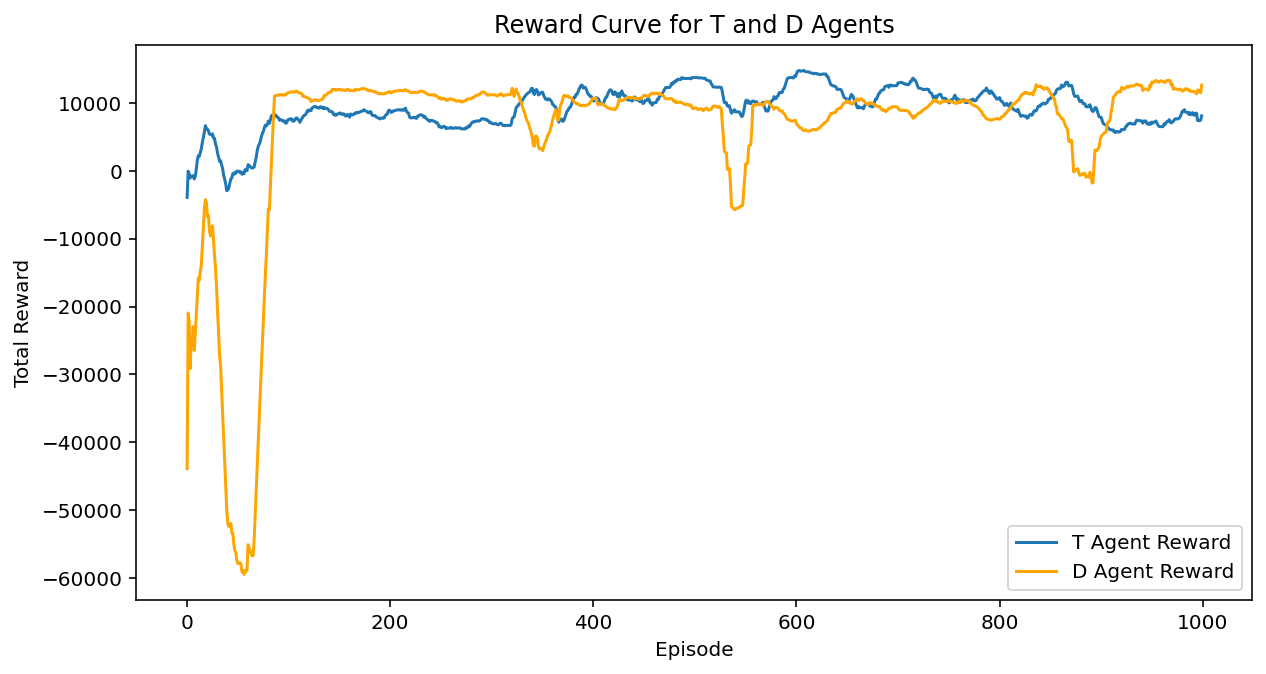

In [19]:
import rl_utils
plt.figure(dpi=144, figsize=(10, 5))
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Curve for T and D Agents")
plt.plot(rl_utils.moving_average(MASAC_T_rewards, 21), label="T Agent Reward")
plt.plot(rl_utils.moving_average(MASAC_D_rewards, 21), label="D Agent Reward", color='orange')
plt.legend()

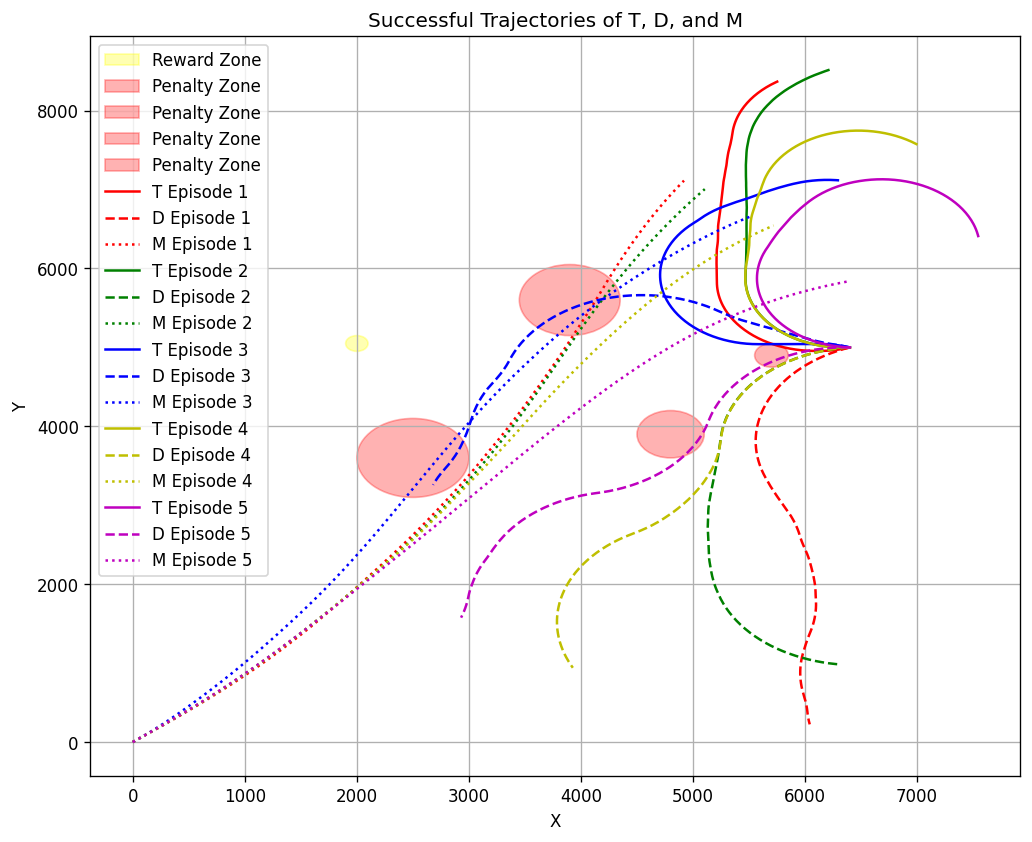

In [20]:
''' 绘制 训练和测试 成功的若干条轨迹 '''
#plot_trajectories( success_trajectories[:min(7,len(success_trajectories))] )
plot_trajectories( sample_trajectories[-5:] )

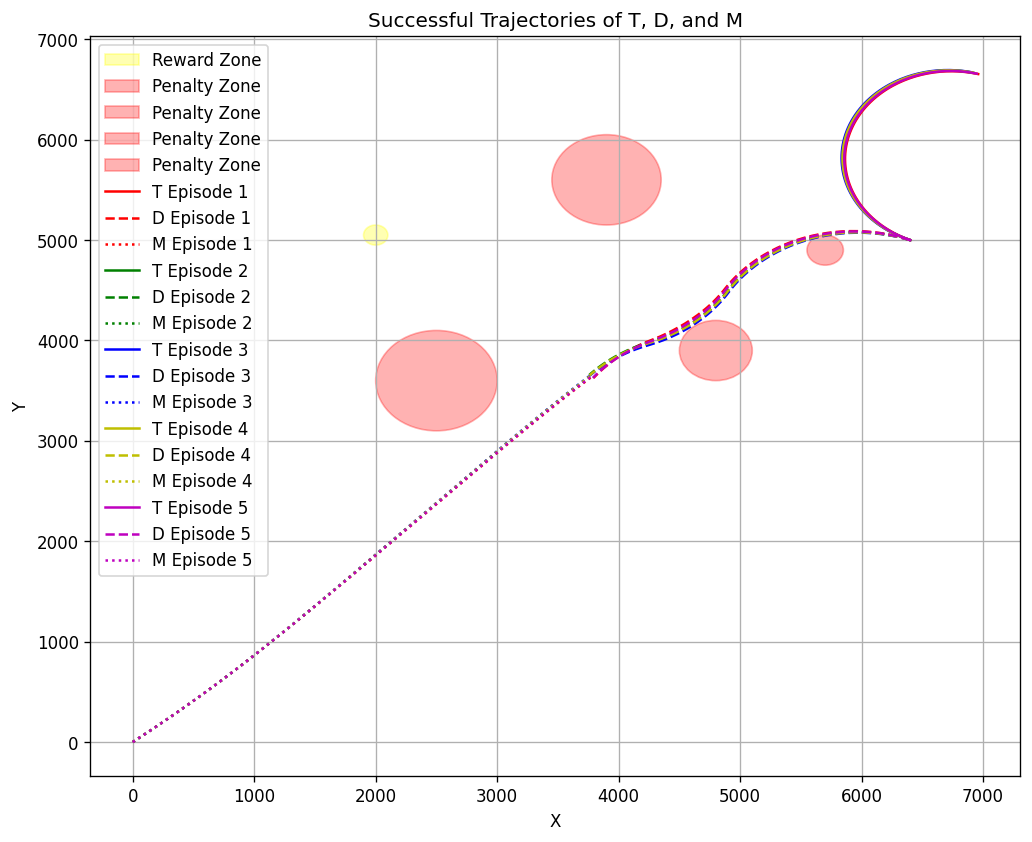

In [21]:
plot_trajectories( test_traj[-5:] )